In [1]:
#!/usr/bin/env python

# --------------------------------------------------------
# Tensorflow Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Xinlei Chen, based on code from Ross Girshick
# --------------------------------------------------------

"""
Demo script showing detections in sample images.

See README.md for installation instructions before running.
"""
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

from model.config import cfg
from model.test import im_detect
from model.nms_wrapper import nms

from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import argparse

from nets.vgg16 import vgg16
from nets.resnet_v1 import resnetv1

import torch

CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('vgg16_faster_rcnn_iter_%d.pth',),'res101': ('res101_faster_rcnn_iter_%d.pth',)}
DATASETS= {'pascal_voc': ('voc_2007_trainval',),'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}


ModuleNotFoundError: No module named 'easydict'

In [ ]:
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


In [ ]:
def demo(net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    #im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im_file = os.path.join(cfg.DATA_DIR, 'VOCdevkit2007', 'VOC2007', 'ImageSets', 'Main', image_name)
    im = cv2.imread(im_file)
    print('Demo for {}'.format(im_file))


    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time(), boxes.shape[0]))

    # Visualize detections for each class
    CONF_THRESH = 0.7
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(torch.from_numpy(dets), NMS_THRESH)
        dets = dets[keep.numpy(), :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)

In [4]:
demonet = 'vgg16' # Network to use [vgg16 res101]
dataset = 'pascal_voc' # Trained dataset [pascal_voc pascal_voc_0712]

In [6]:
torch.cuda.set_device(1)
if True:
    cfg.TEST.HAS_RPN = True  # Use RPN for proposals

    # model path
    #saved_model = os.path.join('../output', demonet, DATASETS[dataset][0], 'default',
    #                          NETS[demonet][0] %(70000 if dataset == 'pascal_voc' else 110000))
    #saved_model = '../output.back/vgg16/custom_2018_trainval_diff/default/vgg16_faster_rcnn_iter_4000.pth'
    #'''
    saved_model = '../output/vgg16/voc_2007_trainval/default/vgg16_faster_rcnn_iter_845000.pth' # 4-class{back, tit, xla, yla}
    CLASSES = ('__background__', 'title', 'xlabel', 'ylabel',  'xticks', 'yticks', 'bars', 'legends')
    '''
    saved_model = '../../project2018/test1/vgg16_faster_rcnn_iter_40000.pth' # 3-class{back, text, ylabel}
    CLASSES = ('__background__', 'text', 'ylabel')
    '''

    if not os.path.isfile(saved_model):
        raise IOError(('{:s} not found.\nDid you download the proper networks from '
                       'our server and place them properly?').format(saved_model))

    # load network
    if demonet == 'vgg16':
        net = vgg16()
    elif demonet == 'res101':
        net = resnetv1(num_layers=101)
    else:
        raise NotImplementedError
    net.create_architecture(len(CLASSES),
                            tag='default', anchor_scales=[8, 16, 32])
    net.load_state_dict(torch.load(saved_model, map_location=lambda storage, loc: storage))
    print(net)

9
/home/xliu/pytorch-faster-rcnn/tools/../lib/nets/network.py
vgg16(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (1

In [7]:
def vis_detections1(ax, im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return


    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')
    '''
    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),   fontsize=14)    
    '''
    
    
    '''
    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    '''


In [8]:
def demo1(net, image_name, CONF_THRESH = 0.7):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    #im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    #im_file = os.path.join(cfg.DATA_DIR, 'VOCdevkit2007', 'VOC2007', 'JPEGImages', image_name)
    
    #im_file = '/home/xliu/checkImageFromGoogle/bs1.png'
    
    #im_file = '/home/xliu/pytorch-faster-rcnn/KNOWLEDGE_FROM_CHARTS/SEMICON_BARS/semi_equipment_materials.jpg'
    im_file = image_name
    im = cv2.imread(im_file)
    print('Demo for {}'.format(im_file))


    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time(), boxes.shape[0]))

    # Visualize detections for each class
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
    #for cls_ind, cls in enumerate(CLASSES[0:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(torch.from_numpy(dets), NMS_THRESH)
        dets = dets[keep.numpy(), :]

        vis_detections1(ax, im, cls, dets, thresh=CONF_THRESH)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

In [9]:
for cls_ind, cls in enumerate(CLASSES[0:]):
    print(cls_ind, cls)

0 __background__
1 title
2 xlabel
3 ylabel
4 xticks
5 yticks
6 bars
7 legends


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/pytorch-faster-rcnn/KNOWLEDGE_FROM_CHARTS/SEMICON_BARS/A-FEA-result-of-package-warpage-for-UFA-at-40C.ppm


/home/xliu/pytorch-faster-rcnn/tools/../lib/nets/network.py:245: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape)
/home/xliu/pytorch-faster-rcnn/tools/../lib/nets/network.py:280: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cls_prob = F.softmax(cls_score)


Detection took 4.314s for 300 object proposals


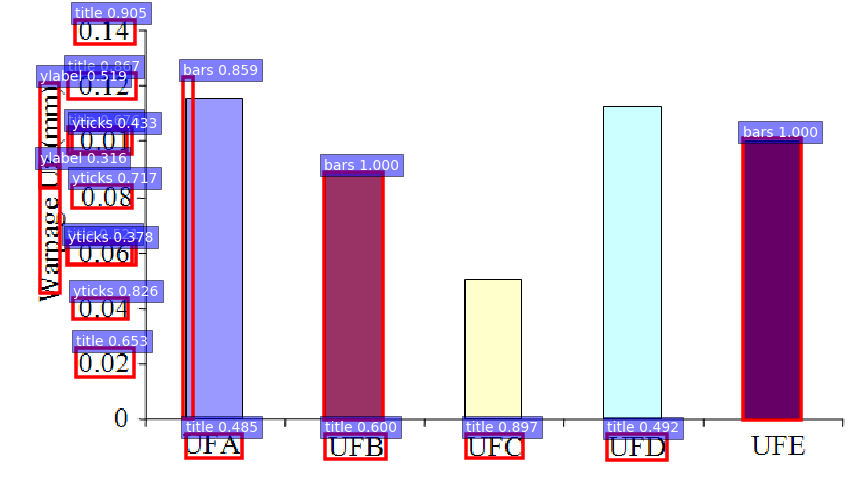

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/pytorch-faster-rcnn/KNOWLEDGE_FROM_CHARTS/SEMICON_BARS/DRAM_chart.gif
Type Unsupported
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/pytorch-faster-rcnn/KNOWLEDGE_FROM_CHARTS/SEMICON_BARS/IPC_graph55873.jpg
Detection took 0.156s for 300 object proposals


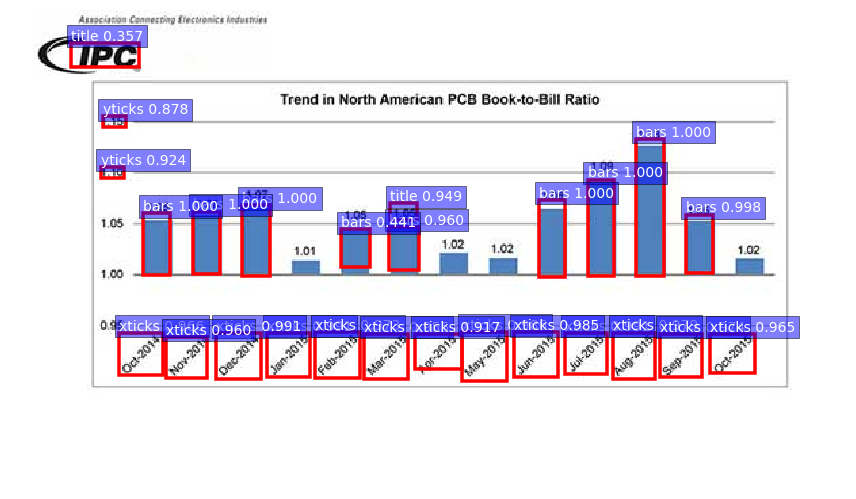

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/pytorch-faster-rcnn/KNOWLEDGE_FROM_CHARTS/SEMICON_BARS/RF-Fig-1.png
Detection took 0.213s for 300 object proposals


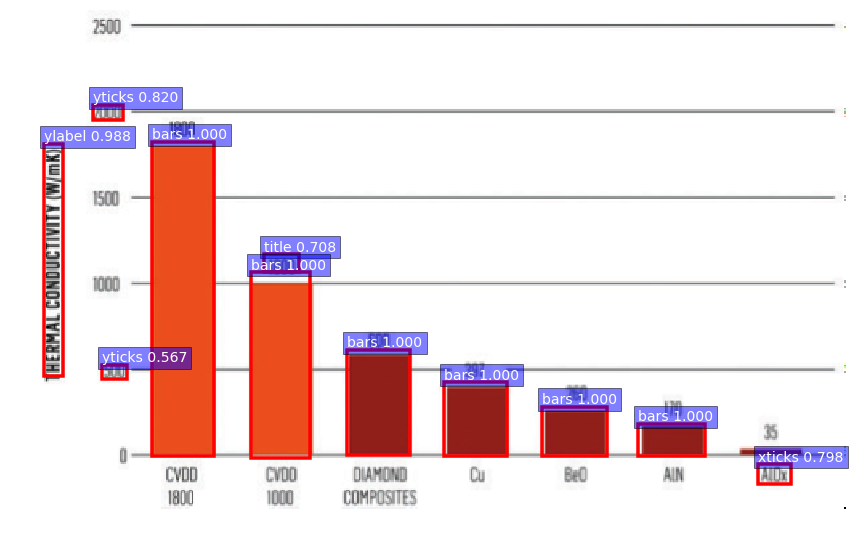

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/pytorch-faster-rcnn/KNOWLEDGE_FROM_CHARTS/SEMICON_BARS/cdnfig2.jpg
Detection took 0.166s for 300 object proposals


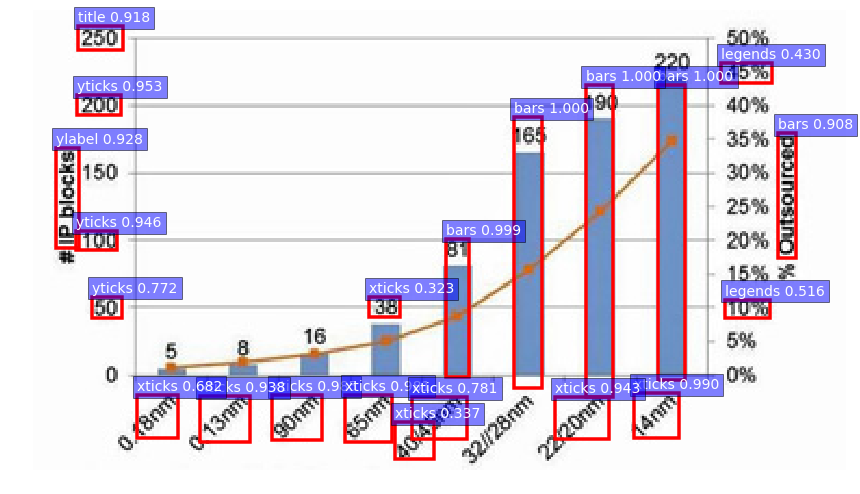

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/pytorch-faster-rcnn/KNOWLEDGE_FROM_CHARTS/SEMICON_BARS/images (11).png
Detection took 0.134s for 300 object proposals


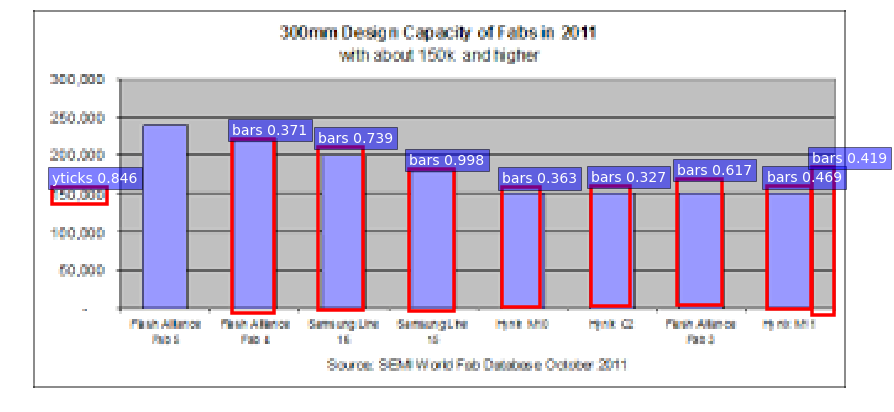

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/pytorch-faster-rcnn/KNOWLEDGE_FROM_CHARTS/SEMICON_BARS/images (7).png
Detection took 0.215s for 300 object proposals


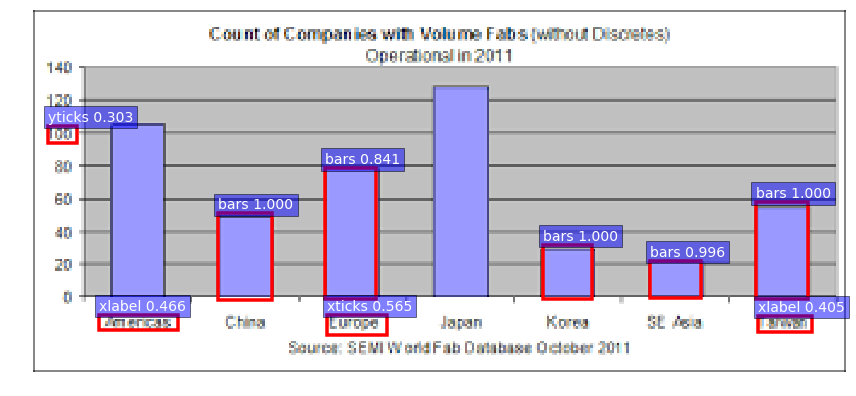

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/pytorch-faster-rcnn/KNOWLEDGE_FROM_CHARTS/SEMICON_BARS/j_polyeng-2017-0347_fig_008.jpg
Detection took 0.160s for 300 object proposals


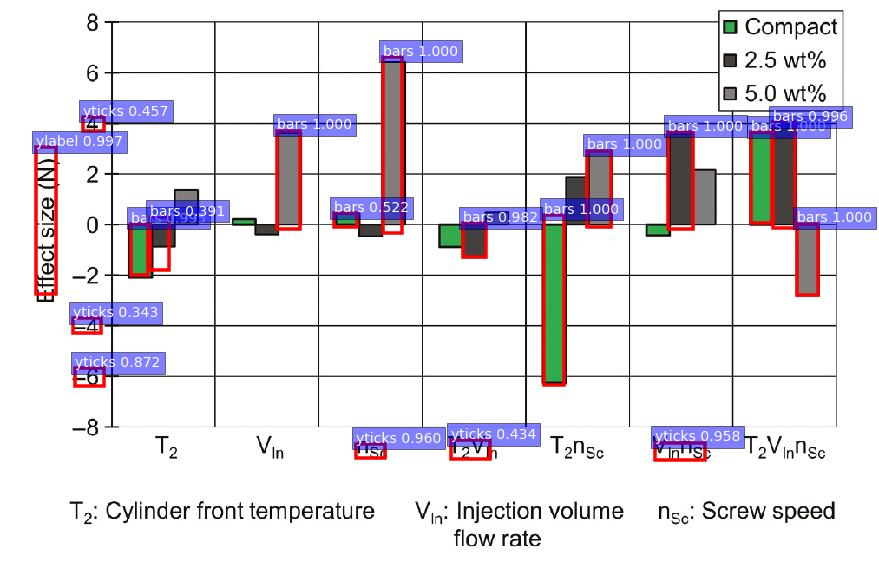

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/pytorch-faster-rcnn/KNOWLEDGE_FROM_CHARTS/SEMICON_BARS/semi_equipment_materials.jpg
Detection took 0.230s for 300 object proposals


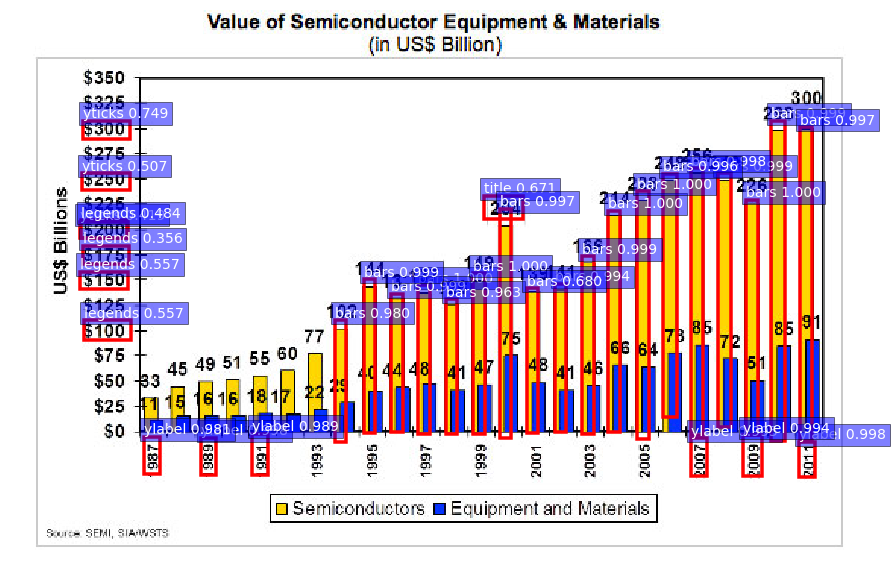

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /home/xliu/pytorch-faster-rcnn/KNOWLEDGE_FROM_CHARTS/SEMICON_BARS/smart phone suppliers.jpg
Detection took 0.242s for 300 object proposals


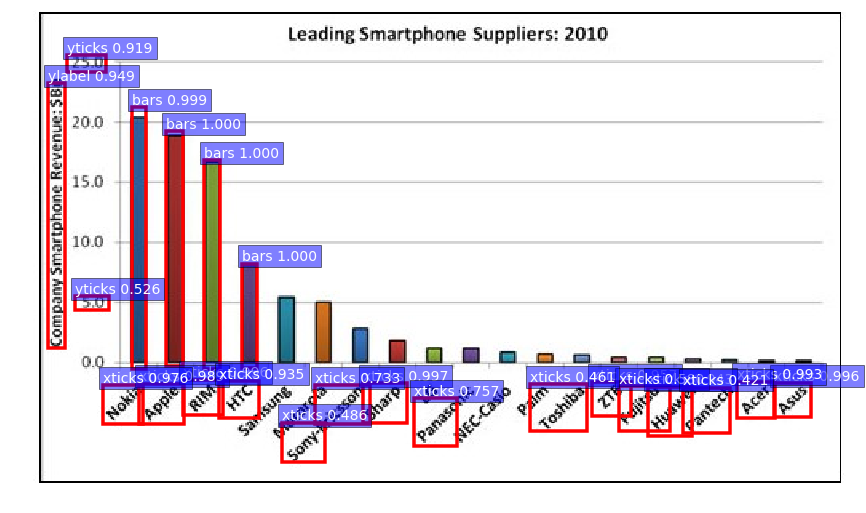

In [13]:
net = net.cuda()
    
    #im_names = ['000456.jpg', '000542.jpg', '001150.jpg',
    #            '001763.jpg', '004545.jpg']
im_names = ['1.jpg']
mypath = '/home/xliu/pytorch-faster-rcnn/KNOWLEDGE_FROM_CHARTS/SEMICON_BARS/'
im_names = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]
#im_names = 
for im_name in im_names:
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    #print('Demo for data/demo/{}'.format(im_name))
    try:
        demo1(net, im_name, CONF_THRESH = 0.3)
        plt.show()
    except:
        print("Type Unsupported")
    #plt.show()

In [11]:
from os import listdir
from os.path import isfile, join

In [12]:
mypath = '/home/xliu/pytorch-faster-rcnn/KNOWLEDGE_FROM_CHARTS/SEMICON_BARS/'
files = [join(mypath, f) for f in listdir(mypath) if isfile(join(mypath, f))]